In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
sns.set(color_codes=True)

import shap
shap.initjs()

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
train_data = pd.read_csv("main_after_feature.csv",index_col=0)
hist_data = pd.read_csv("hist_after_feature.csv",index_col=0)

In [3]:
hist_data = hist_data.drop('churn',axis=1)
train_data.churn = train_data.churn.replace({'Churned':1,'Stayed':0})

In [4]:
train = pd.merge(train_data,hist_data,on="id")

In [5]:
pd.DataFrame({"Dataframe columns": train.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_p1
8,forecast_price_energy_p2
9,forecast_price_pow_p1


### Splitting data

In [6]:
y = train["churn"]
X = train.drop(labels = ["id","churn"],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)

#### XGBClassifier

In [7]:
model = xgb.XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=500,n_jobs=-1,verbosity = 0,use_label_encoder=False)
result = model.fit(X_train,y_train)

---
#### Model evaluation

In [8]:
def evaluate(model_, X_test_, y_test_):
 """
 Evaluate the accuracy, precision and recall of a model
 """

 # Get the model predictions
 prediction_test_ = model_.predict(X_test_)

 # Print the evaluation metrics as pandas dataframe
 results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test_, prediction_test_)],
 "Precision" : [metrics.precision_score(y_test_, prediction_test_)],
 "Recall" : [metrics.recall_score(y_test_, prediction_test_)]})

 # For a more detailed report
 #print(metrics.classification_report(y_test_, prediction_test_))
 return results

In [9]:
evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall
0,0.910947,0.917166,0.991273


In [10]:
def calculate_roc_auc(model_, X_test_, y_test_):
 """
 Evaluate the roc-auc score
 """

 # Get the model predictions
 # Note that we are using the prediction for the class 1 -> churn
 prediction_test_ = model_.predict_proba(X_test_)[:,1]
 # Compute roc-auc
 fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)

 # Print the evaluation metrics as pandas dataframe
 score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
 return fpr, tpr, score
def plot_roc_auc(fpr,tpr):
 """
 Plot the Receiver Operating Characteristic from a list
 of true positive rates and false positive rates.
 """

 # Initialize plot
 f, ax = plt.subplots(figsize=(14,8))

 # Plot ROC
 roc_auc = metrics.auc(fpr, tpr)
 ax.plot(fpr, tpr, lw=2, alpha=0.3,
 label="AUC = %0.2f" % (roc_auc))
 # Plot the random line.
 plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
 label="Random", alpha=.8)

 # Fine tune and show the plot.
 ax.set_xlim([-0.05, 1.05])
 ax.set_ylim([-0.05, 1.05])
 ax.set_xlabel("False Positive Rate (FPR)")
 ax.set_ylabel("True Positive Rate (TPR)")
 ax.set_title("ROC-AUC")
 ax.legend(loc="lower right")
 plt.show()

In [11]:
fpr, tpr, auc_score = calculate_roc_auc(model, X_test, y_test)

In [12]:
auc_score

,ROC-AUC
0,0.697971


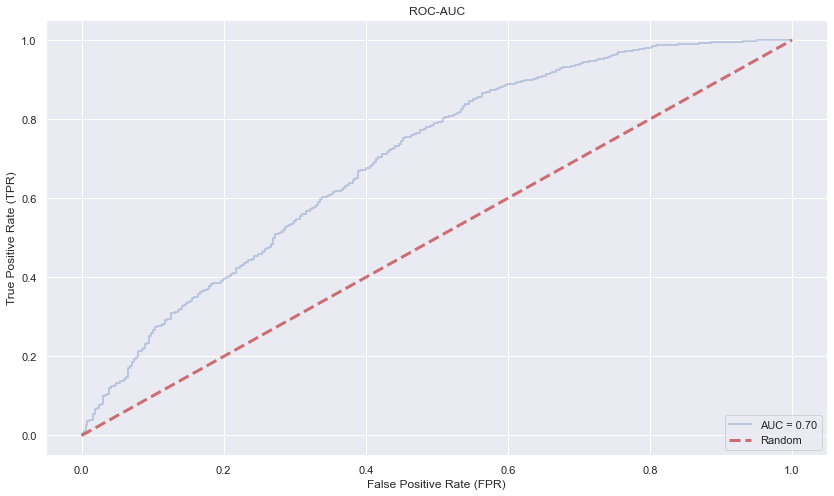

In [13]:
plot_roc_auc(fpr, tpr)
plt.show()

#### Stratified K-fold validation

In [14]:
def plot_roc_curve(fprs, tprs):
 """
 Plot the Receiver Operating Characteristic from a list
 of true positive rates and false positive rates.
 """

 # Initialize useful lists + the plot axes.
 tprs_interp = []
 aucs = []
 mean_fpr = np.linspace(0, 1, 100)
 f, ax = plt.subplots(figsize=(18,10))

 # Plot ROC for each K-Fold + compute AUC scores.
 for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
     tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
     tprs_interp[-1][0] = 0.0
     roc_auc = metrics.auc(fpr, tpr)
     aucs.append(roc_auc)
     ax.plot(fpr, tpr, lw=2, alpha=0.3,
     label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))

 # Plot the luck line.
 plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
 label="Random", alpha=.8)

 # Plot the mean ROC.
 mean_tpr = np.mean(tprs_interp, axis=0)
 mean_tpr[-1] = 1.0
 mean_auc = metrics.auc(mean_fpr, mean_tpr)
 std_auc = np.std(aucs)
 ax.plot(mean_fpr, mean_tpr, color='b',
 label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
 lw=4, alpha=.8)

 # Plot the standard deviation around the mean ROC.
 std_tpr = np.std(tprs_interp, axis=0)
 tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
 tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
 ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
 label=r"$\pm$ 1 std. dev.")

 # Fine tune and show the plot.
 ax.set_xlim([-0.05, 1.05])
 ax.set_ylim([-0.05, 1.05])
 ax.set_xlabel("False Positive Rate (FPR)")
 ax.set_ylabel("True Positive Rate (TPR)")
 ax.set_title("ROC-AUC")
 ax.legend(loc="lower right")
 plt.show()
 return (f, ax)
def compute_roc_auc(model_, index):
 y_predict = model_.predict_proba(X.iloc[index])[:,1]
 fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict)
 auc_score = metrics.auc(fpr, tpr)
 return fpr, tpr, auc_score

In [15]:
cv = StratifiedKFold(n_splits=10, random_state=13, shuffle=True)
fprs, tprs, scores = [], [], []

In [16]:
for (train, test), i in zip(cv.split(X, y), range(10)):
 model.fit(X.iloc[train], y.iloc[train])
 _, _, auc_score_train = compute_roc_auc(model, train)
 fpr, tpr, auc_score = compute_roc_auc(model, test)
 scores.append((auc_score_train, auc_score))
 fprs.append(fpr)
 tprs.append(tpr)

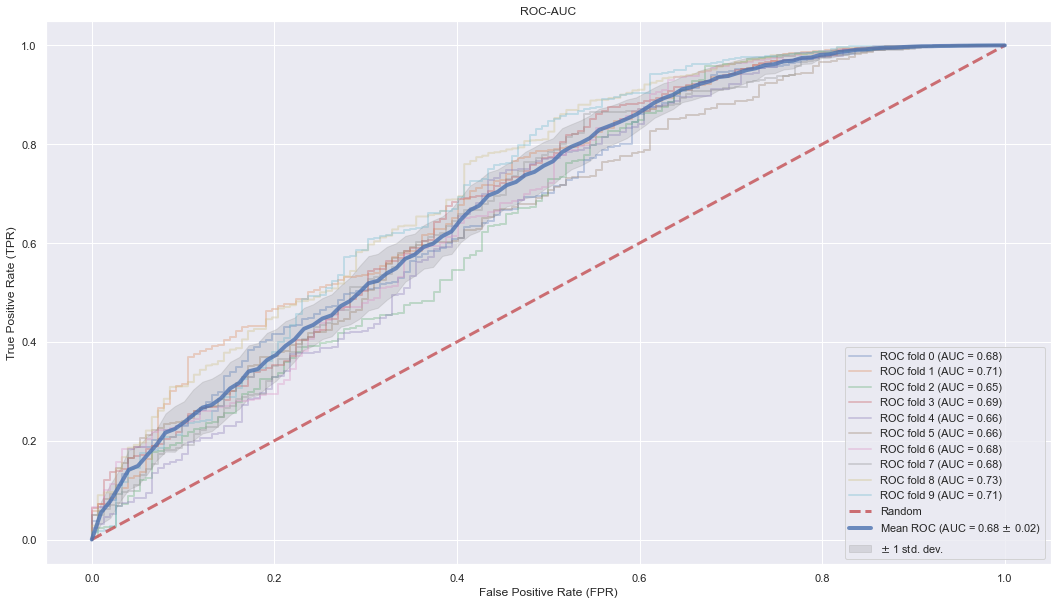

In [17]:
plot_roc_curve(fprs, tprs)
plt.show()

#### Random Search Cross Validation

In [18]:
from sklearn.model_selection import RandomizedSearchCV

params = {
 'min_child_weight': [i for i in np.arange(1,15,1)],
 'gamma': [i for i in np.arange(0,6,0.5)],
 'subsample': [i for i in np.arange(0,1.1,0.1)],
 'colsample_bytree': [i for i in np.arange(0,1.1,0.1)],
 'max_depth': [i for i in np.arange(1,15,1)],
 'scale_pos_weight':[i for i in np.arange(1,15,1)],
 'learning_rate': [i for i in np.arange(0,0.15,0.01)],
 'n_estimators' : [i for i in np.arange(0,2000,100)]
 }

xg = xgb.XGBClassifier(objective='binary:logistic',
 silent=True,use_label_encoder=False)

In [19]:
xg_random = RandomizedSearchCV(xg, param_distributions=params,n_iter=1, 
                               scoring= "roc_auc",n_jobs=-1, cv=5, verbose=3, random_state=1001)

xg_random.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                        

In [24]:
best_random = {'subsample': 0.8,
'scale_pos_weight': 1,
'n_estimators': 1100,
'min_child_weight': 1,
'max_depth': 12,
'learning_rate': 0.01,
'gamma': 4.0,
'colsample_bytree': 0.60}

In [395]:
model_random = xgb.XGBClassifier(objective='binary:logistic',silent=True, nthread=-1, **best_random,use_label_encoder=False)
fprs, tprs, scores = [], [], []

In [396]:
for (train, test), i in zip(cv.split(X, y), range(5)):
 model_random.fit(X.iloc[train], y.iloc[train])
 _, _, auc_score_train = compute_roc_auc(model_random, train)
 fpr, tpr, auc_score = compute_roc_auc(model_random, test)
 scores.append((auc_score_train, auc_score))
 fprs.append(fpr)
 tprs.append(tpr)
 if i == 1:
    oof_x = X.iloc[test]
    oof_y = y.iloc[test]
    train_dataX = X.iloc[train]
    train_dataY = y.iloc[train]

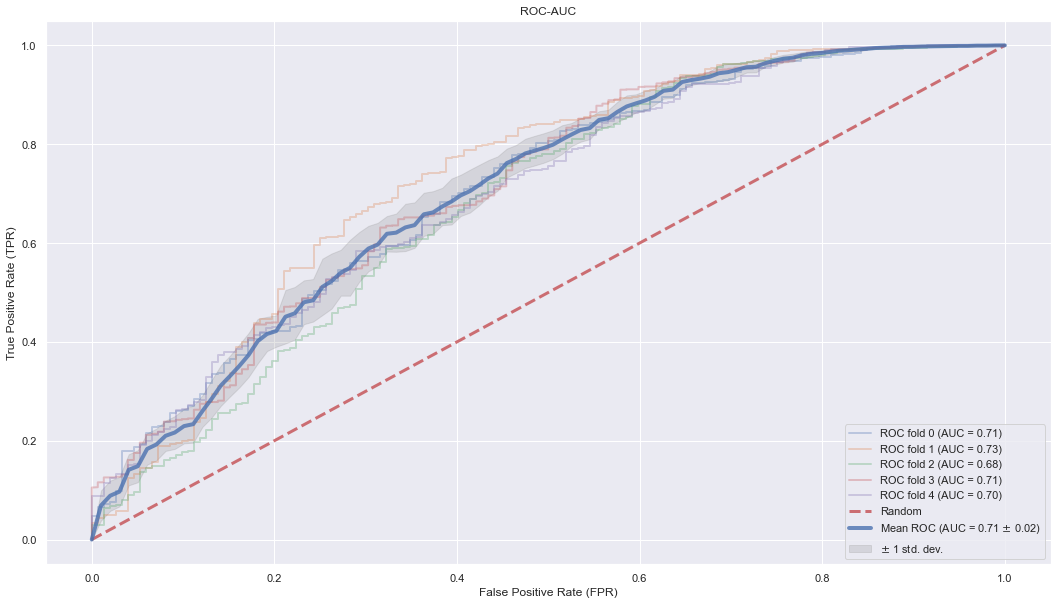

In [397]:
plot_roc_curve(fprs, tprs)
plt.show()

#### Understanding the model

One simple way of boserving the feature importance is through counting the number of times each feature is split on across all boosting rounds (trees)
in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

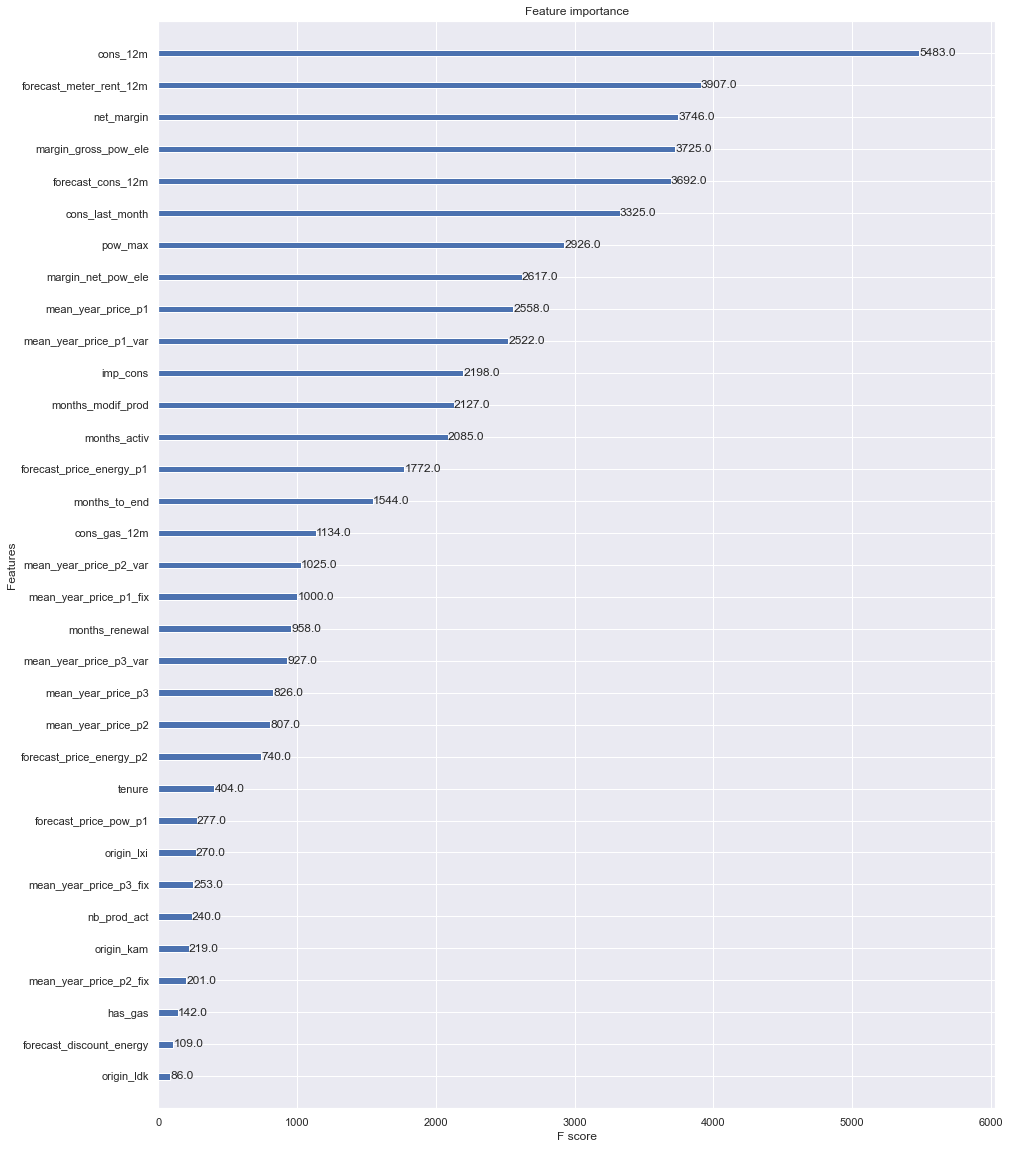

In [28]:
fig, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(model_random, ax=ax)

In the feature importance graph above we can see that "cons_12m" and "forecast_meter_rent_12m" are the features that appear the most in our model and
we could infere that these two features have a significant importnace in our model

In [398]:
oof_x.to_csv("oof_x.csv")
oof_y.to_csv("oof_y.csv")

In [399]:
train_dataX.to_csv("train_dataX.csv")
train_dataY.to_csv("train_dataY.csv")

# Let's Check if applying 20% discount will affect the churn probability

In [401]:
predictions = pd.read_csv("oof_x.csv",index_col=0)
x = pd.read_csv("oof_y.csv",index_col=0)
predictions = predictions.reset_index()
x = x.reset_index()
predictions = pd.merge(predictions,x)
predictions = predictions.drop("index", axis=1)

In [406]:
X_train = pd.read_csv("train_dataX.csv",index_col=0)
y_train = pd.read_csv("train_dataY.csv",index_col=0)
X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_train = X_train.drop('index',axis=1)
y_train = y_train.drop('index',axis=1)

### Let's calculate the avarge churn probability for the selected samples before applying the discount

In [410]:
X_train['basecase_revenue'] = X_train['forecast_cons_12m'] * X_train['forecast_price_energy_p1'] + X_train['forecast_meter_rent_12m']

In [414]:
X_test = predictions.drop('churn',axis=1)
X_test['basecase_revenue'] = X_test['forecast_cons_12m'] * X_test['forecast_price_energy_p1'] + X_test['forecast_meter_rent_12m']

In [415]:
model_random.fit(X_train,y_train)
pred_prob = pd.DataFrame(model_random.predict_proba(X_test))

In [418]:
print("The avg Churn Prob. Is: ", pred_prob[1].mean())

The avg Churn Prob. Is:  0.9155407547950745


In [445]:
print("Number of customers has high churn prob.:",len(pred_prob[1].loc[pred_prob[1]<=0.7]))

Number of customers has high churn prob.: 33


In [424]:
Total = X_test.basecase_revenue.sum()
print("The total rev is: ", "{:.2f}".format(Total),"$")

The total rev is:  503988.40 $


### Now lets see if applying the discount will change any thing

In [273]:
predictions_cc = predictions

In [428]:
predictions_cc.loc[predictions_cc.predict_prob >= 0.5,'forecast_price_energy_p1'] = predictions_cc.loc[predictions_cc.predict_prob >= 0.5,'forecast_price_energy_p1'] - (predictions_cc.loc[predictions_cc.predict_prob >= 0.5,'forecast_price_energy_p1']*0.20)
predictions_cc.loc[predictions_cc.predict_prob >= 0.5,'forecast_meter_rent_12m'] = predictions_cc.loc[predictions_cc.predict_prob >= 0.5,'forecast_meter_rent_12m'] - (predictions_cc.loc[predictions_cc.predict_prob >= 0.5,'forecast_meter_rent_12m']*0.20)
predictions_cc.basecase_revenue = predictions_cc['forecast_cons_12m'] * predictions_cc['forecast_price_energy_p1'] + predictions_cc['forecast_meter_rent_12m']

In [429]:
predictions_cc.head(1)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,churn,basecase_revenue,predict_prob
0,7726.0,0.0,0.0,914.1,0.0,47.7824,0.103889,0.084428,44.311378,0,0.0,33.12,33.12,1,89.02,13.2,4,35.0,12.0,1.0,0.0,0,0,1,0,0,0.169177,0.08764,0.0,44.311375,0.0,0.0,44.480553,0.08764,0.0,1,142.747591,0.811129


In [430]:
X_test = predictions_cc.drop(labels={'churn','predict_prob'},axis=1)
predictions_cc = predictions_cc.drop('predict_prob',axis=1)

In [431]:
pred_prob_after = model_random.predict_proba(X_test)

In [434]:
pred_prob_after = pd.DataFrame(pred_prob_after)

In [435]:
print("The avg Churn Prob. Is: ", pred_prob_after[1].mean())

The avg Churn Prob. Is:  0.9103053212165833


In [444]:
print("Number of customers has high churn prob.:",len(pred_prob_after[1].loc[pred_prob_after[1]<=0.7]))

Number of customers has high churn prob.: 43


In [437]:
Total = predictions_cc.basecase_revenue.sum()
print("The total rev is: ", "{:.2f}".format(Total),"$")

The total rev is:  395475.52 $
